# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error)
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $w$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    df_dx = 2 * np.sin(w[0]) * np.cos(w[0])
    df_dy = 2 * np.sin(w[1]) * np.cos(w[1])
    gradient = np.array([df_dx, df_dy])
    return gradient

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)#рандомная инициализация
    print(w0)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr * grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

[0.61217018 0.16906975]


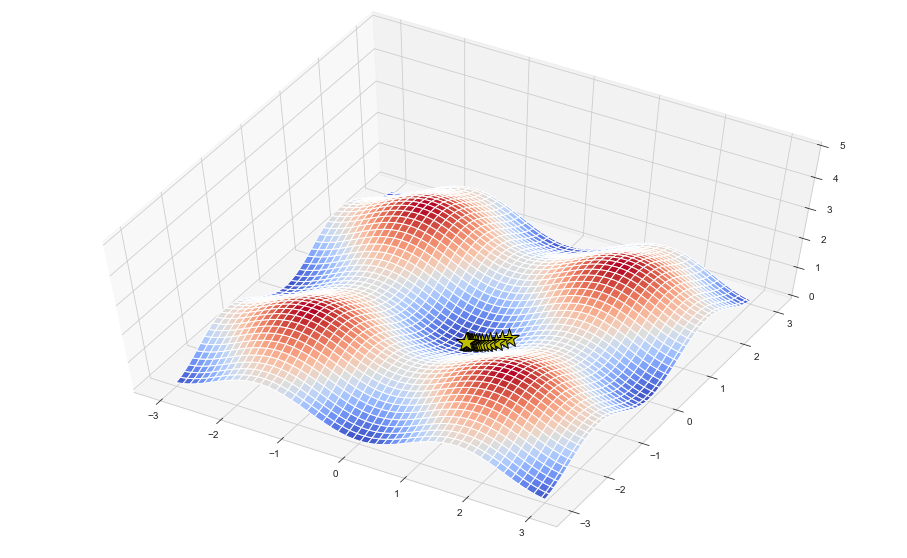

In [8]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

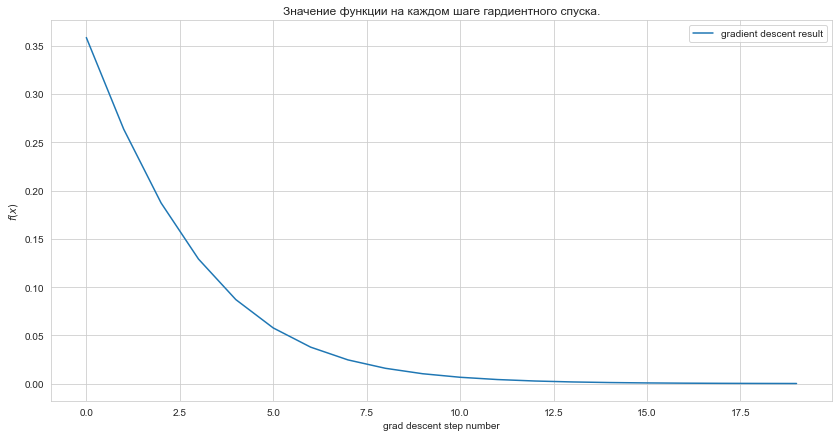

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    mse = 1 / n * np.sum((y_true - y_pred) **2)
    return mse


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    gradient = 2 / n * np.matmul(np.transpose(X), (y_pred - y_true))
    return gradient


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):#считает грациент MSE на конкретном шаге
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):#выбор нормы градиента
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [12]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):#по сути надо подобрать омеги
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [13]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):#предикт мы берём и в обучение, и в непосредственное предсказание
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        """
        YOUR CODE IS HERE
        """
        #print(f'X_test = {X_test.shape}, self.W = {self.W.shape}')
        #print(f'X_test = {X_test}, self.W = {self.W}')
        #y_pred = X_test * self.W
        y_pred = np.matmul(X_test, self.W)
        return y_pred
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

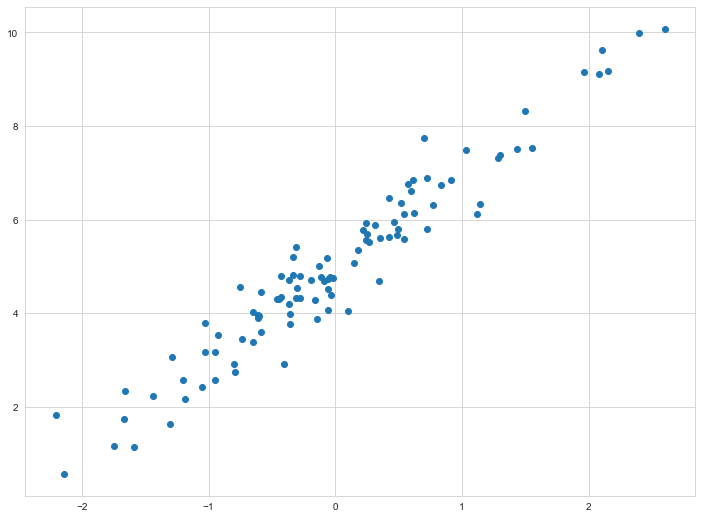

In [15]:
plt.scatter(X, y);

In [16]:
custom_lin_reg = CustomLinearRegression()

In [17]:
custom_lin_reg.fit(X, y)

My custom linear regression

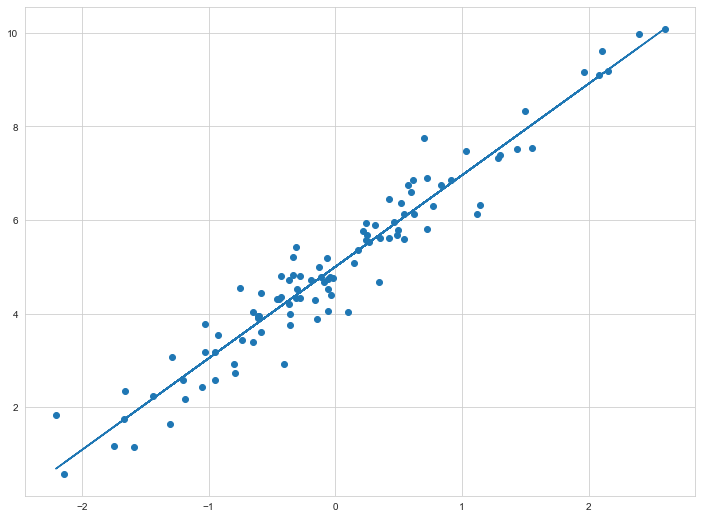

In [18]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [19]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

**Пояснения по датафрейму:**

Данные домов в кварталах Калифорнии.

* MedInc - median income in block group (ср доход)
* HouseAge - median house age in block group (ср возраст дома)
* AveRooms - average number of rooms per household (ср кол-во комнат)
* AveBedrms - average number of bedrooms per household (ср кол-во спален)
* Population - block group population (население)
* AveOccup - average number of household members (ср кол-во проживающих)
* Latitude - block group latitude (широта)
* Longitude - block group longitude (долгота)

Целевая переменная - медиана стоимости дома в округе [сотни тысяч долларов]

In [20]:
#Работаем с датафреймом:
df = pd.DataFrame(X, columns = feature_names)

In [21]:
#глянем
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [22]:
print(f'Строк и колонок: {df.shape}')

Строк и колонок: (20640, 8)


In [23]:
#глянем на типы данных
df.dtypes
#они у нас в целом все числовые => Поэтому будем стандартизовать все колонки

MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
dtype: object

In [24]:
#Краткая сводка
df.describe()
#видно, что данные не стандартизованы => Будем стандартизовать

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [25]:
#Кол-во NA
print(f'Количество NA: {(df.isnull().sum()).sum()}')
#Na тоже нет => Нечего выкидывать/заполнять

Количество NA: 0


In [26]:
#Дубликаты
print(f'Количество дубликатов: {(df[df.duplicated()]).shape[0]}')
#их нет => Чистить не надо

Количество дубликатов: 0


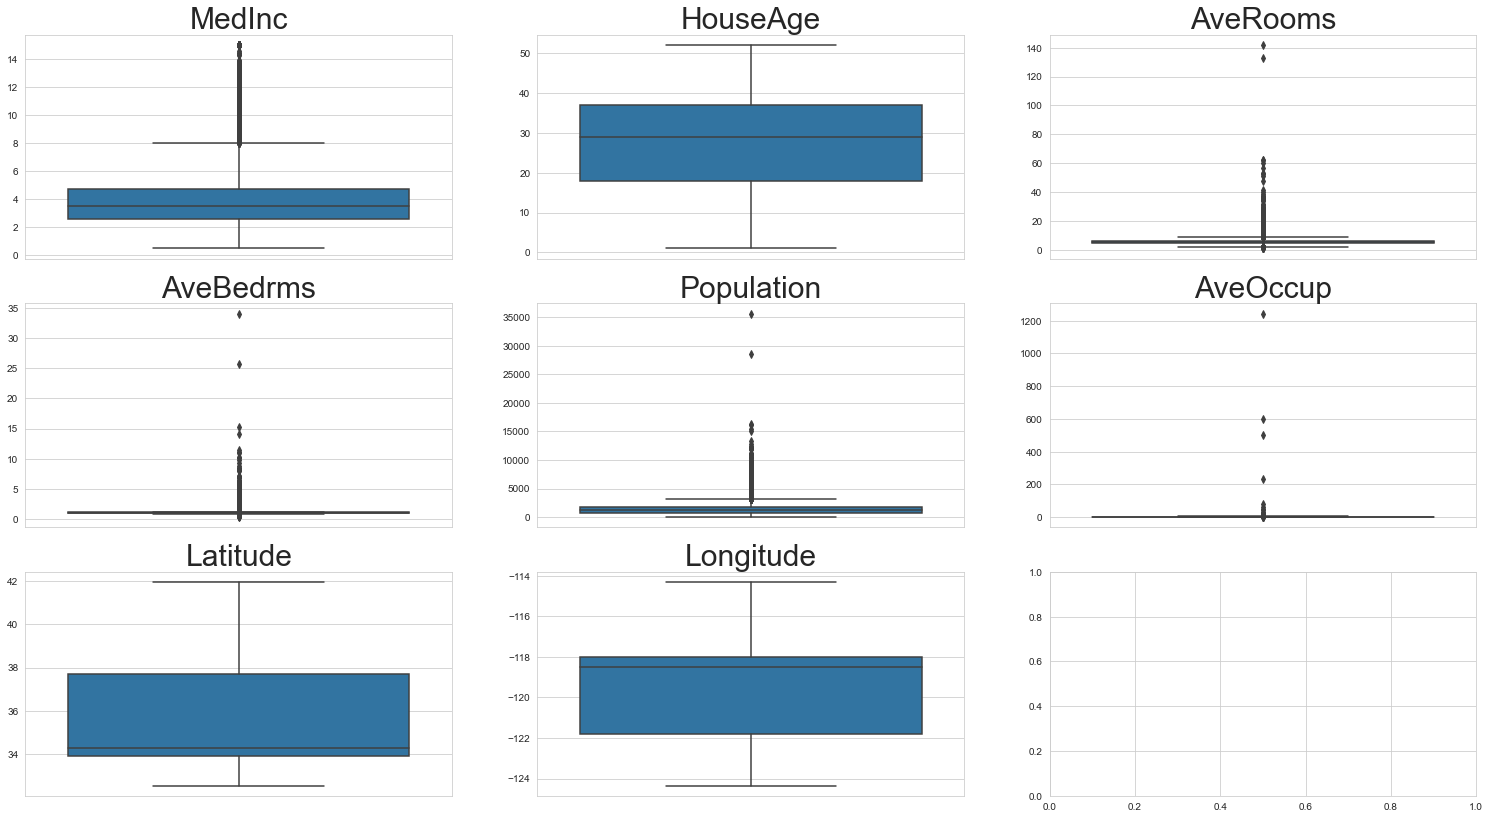

In [27]:
#посмотрим боксплоты:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (26, 14))
axes = axes.ravel()
for col, ax in zip(df.columns, axes):
  sns.boxplot(y = df[col], ax=ax)
  ax.set_title(col, size = 30)
  ax.set(xlabel='', ylabel='')
#как будто есть выбросы у MedInc, AveRooms, AveBedrms, Population, AveOccup (но как будто такое может быть. Кто-то может иметь высокий доход, среднее количество комнат и спален, ну и популяция различаться - какой-нибудь небоскрёб там стоит один)


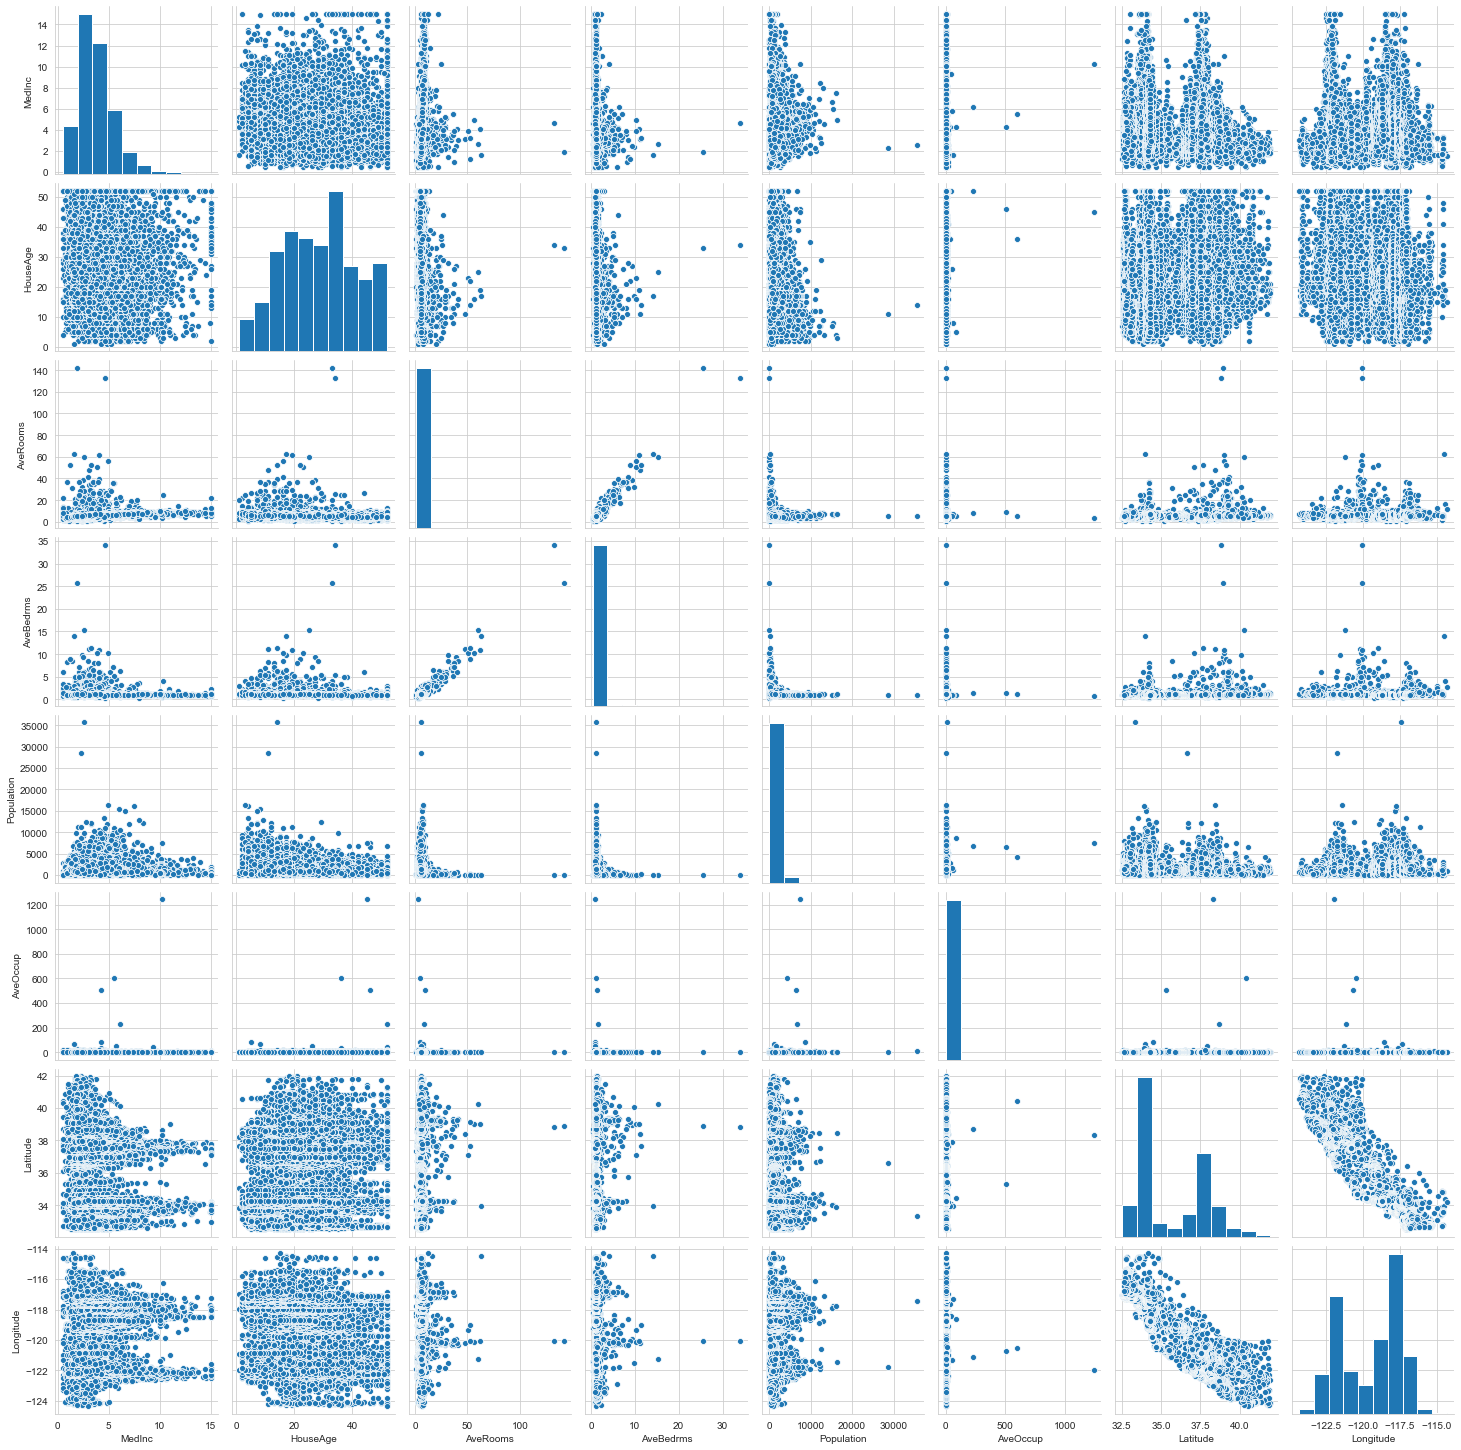

In [28]:
#гистограммы и скеттеры
sns.pairplot(df)

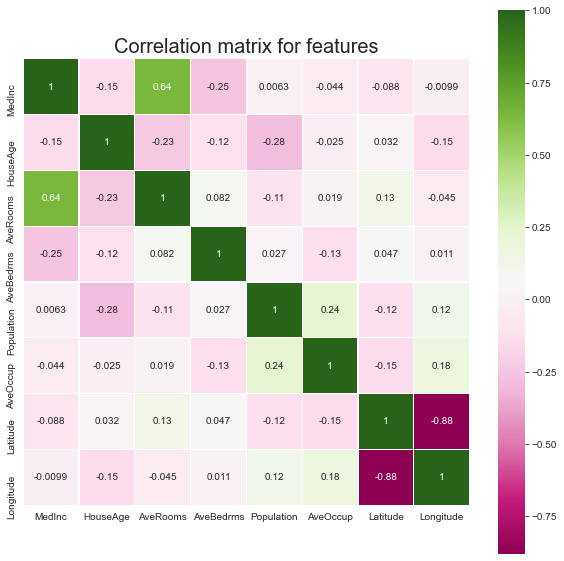

In [29]:
#корреляции
correlations = df.corr(method='spearman') 
plt.figure(figsize = (10,10))
sns.heatmap(correlations, square = True, annot = True, linewidths = 0.25, cmap = 'PiYG')
plt.title("Correlation matrix for features", size = 20)
plt.show()
#только у широты/долготы корреляция высокая, в остальном норм

In [30]:
#тест/трейн сплит
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = SEED)

print(f'Train: X - {X_train.shape}, y - {y_train.shape}\nTest: X - {X_test.shape}, y - {y_test.shape}')

Train: X - (16512, 8), y - (16512,)
Test: X - (4128, 8), y - (4128,)


In [31]:
#стандартизация
scaler = StandardScaler().fit(X_train)
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
#линейная регрессия
lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

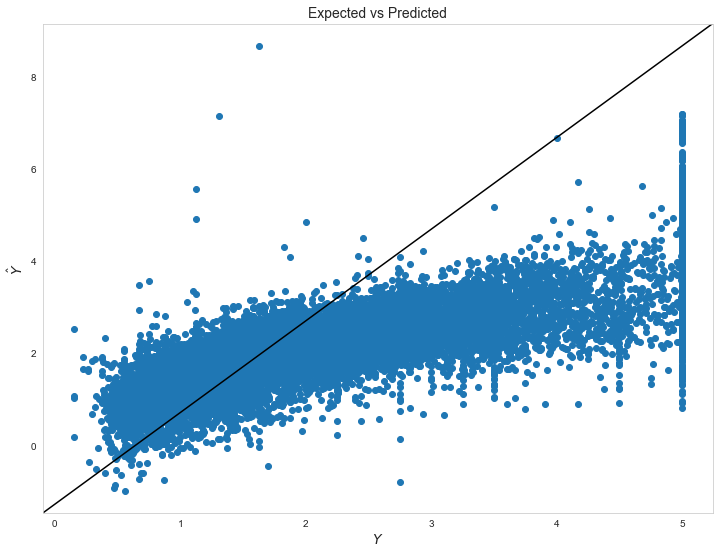

In [33]:
#

# fig = plt.figure()
plt.scatter(y_train, lm.predict(X_train)) # plt.gca().scatter(...)
plt.grid() # plt.gca().grid()
plt.xlabel("$Y$", fontweight='bold', fontsize=14) # plt.gca().set_xlabel(...)
plt.ylabel("$\hat{Y}$", fontweight='bold', fontsize=14) # plt.gca().set_ylabel(...)
plt.title("Expected vs Predicted", fontsize=14) # plt.gca().set_title(...)

# Diagonal line
ax = plt.gca()
ax.plot([0, 1], [0, 1], color='black', transform=ax.transAxes)
# plt.show()

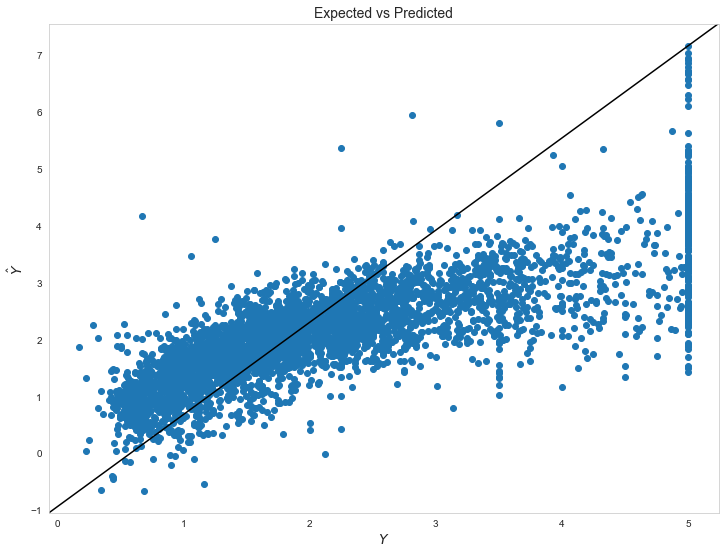

In [34]:

# fig = plt.figure()
plt.scatter(y_test, lm.predict(X_test)) # plt.gca().scatter(...)
plt.grid() # plt.gca().grid()
plt.xlabel("$Y$", fontweight='bold', fontsize=14) # plt.gca().set_xlabel(...)
plt.ylabel("$\hat{Y}$", fontweight='bold', fontsize=14) # plt.gca().set_ylabel(...)
plt.title("Expected vs Predicted", fontsize=14) # plt.gca().set_title(...)

# Diagonal line
ax = plt.gca()
ax.plot([0, 1], [0, 1], color='black', transform=ax.transAxes)
# plt.show()

In [35]:
#метрики
mse = mean_squared_error(y_true = y_test, y_pred = y_pred)
r2 = r2_score(y_true = y_test, y_pred = y_pred)
print(f'Mean square error = {mse}\nR-Square = {r2}')

Mean square error = 0.5405661575783066
R-Square = 0.5961285884453014


In [36]:
#чекнем коэффициенты
print(f'Коэффициенты линейной регрессии (омеги): {lm.coef_}\n')

#Но попонятнее будет так:
model_feature = feature_names.copy()
model_feature.insert(0, 'intercept')
indexes = np.argsort(np.abs(lm.coef_), )[::-1]
print(f'По убыванию важности признака: {[model_feature[i] for i in indexes]}')

Коэффициенты линейной регрессии (омеги): [ 0.82824232  0.12153239 -0.26117647  0.30524043 -0.00653505 -0.03964943
 -0.888757   -0.85848682]

По убыванию важности признака: ['AveOccup', 'Latitude', 'intercept', 'AveRooms', 'HouseAge', 'MedInc', 'Population', 'AveBedrms']


In [37]:
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer().fit(X_train)
X_train_transf = scaler.transform(X_train)
X_test_transf = scaler.transform(X_test)

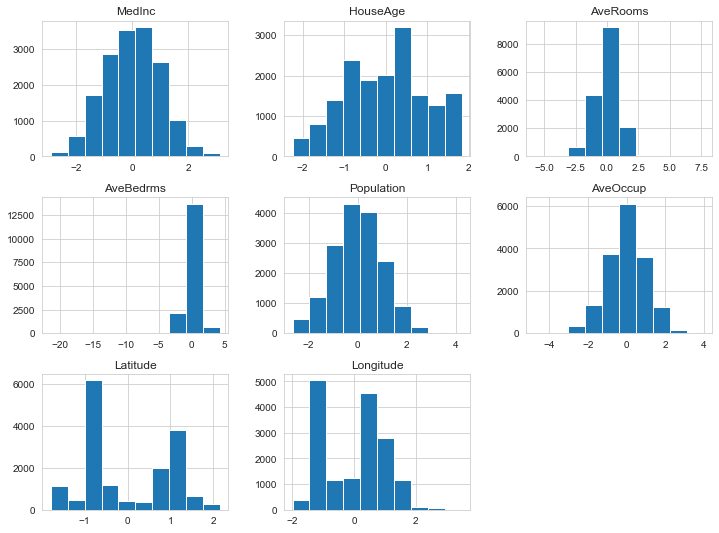

In [38]:
pd.DataFrame(X_train_transf, columns=feature_names).hist();
#стало лучше (как минимум с MedInc и Population)

In [39]:
#линейная регрессия
lm = LinearRegression()
lm.fit(X_train_transf, y_train)
y_pred = lm.predict(X_test_transf)

#метрики
mse = mean_squared_error(y_true = y_test, y_pred = y_pred)
r2 = r2_score(y_true = y_test, y_pred = y_pred)
print(f'Mean square error = {mse}\nR-Square = {r2}\n')

#чекнем коэффициенты
print(f'Коэффициенты линейной регрессии: {lm.coef_}\n')

#Но попонятнее будет так:
model_feature = feature_names.copy()
model_feature.insert(0, 'intercept')
indexes = np.argsort(np.abs(lm.coef_), )[::-1]
print(f'По убыванию важности признака: {[model_feature[i] for i in indexes]}')

Mean square error = 0.5134505410140942
R-Square = 0.6163873896733048

Коэффициенты линейной регрессии: [ 0.79959921  0.15809721 -0.12171139  0.14485077  0.00764522 -0.25326606
 -0.85862966 -0.80207416]

По убыванию важности признака: ['AveOccup', 'Latitude', 'intercept', 'Population', 'MedInc', 'AveRooms', 'HouseAge', 'AveBedrms']


mse чутка уменьшилось (хорошо), R2 подрос (тоже хорошо). Даже изменился порядок признаков.

Но я ожидала кнш бОльшего эффекта.

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [40]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    probability = 1 / (1 + np.exp(-output))
    return probability

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [41]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)#Clip (limit) the values in an array.
    
    bce_value = 1 / n * np.sum(-(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)))
    return bce_value
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    gradient = np.matmul(np.transpose(X), (y_pred - y_true))
    return gradient


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [42]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        #y_pred = sigmoid(np.matmul(X_test, self.W))
        probability = sigmoid(np.matmul(X_test, self.W))
        #так, тут вроде нет нигде аттрибута для задания порога, поэтому возьмём порог 0,5
        y_pred = np.where(probability > 0.5, 1, 0)
        return y_pred
    
    def predict_prob(self, X_test):#для рока аука и ради интереса дописать
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        #y_pred = sigmoid(np.matmul(X_test, self.W))
        probability = sigmoid(np.matmul(X_test, self.W))
        return probability
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [43]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

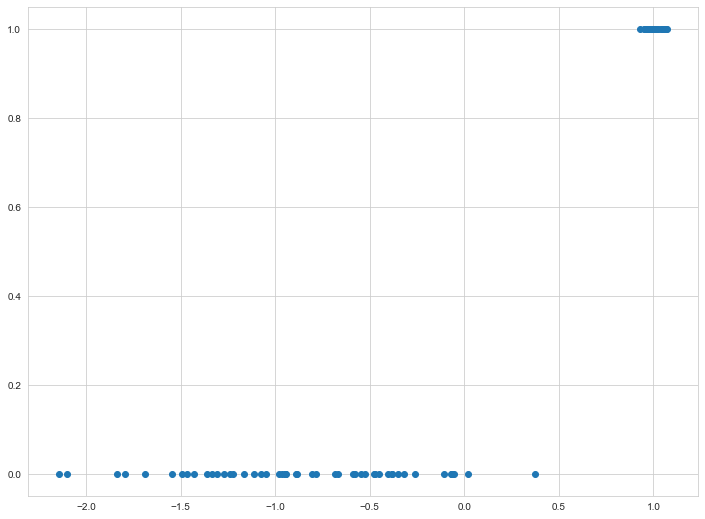

In [44]:
plt.scatter(X, y);

In [45]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

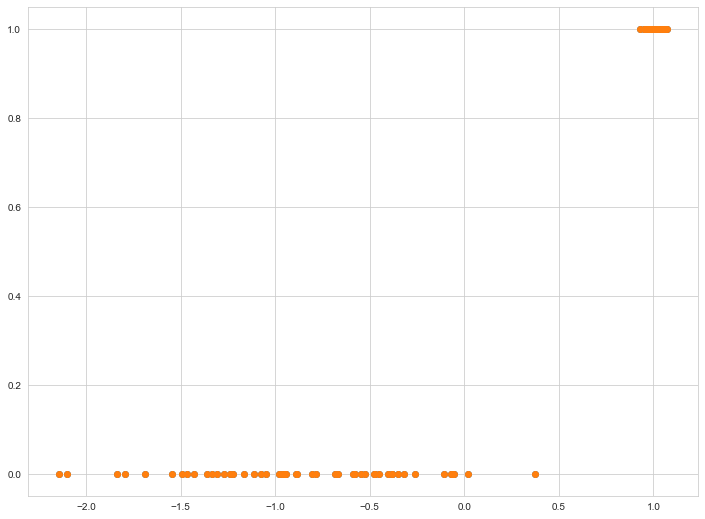

In [46]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(f'Accuracy = {accuracy_score(y, y_pred)}\nPrecision = {precision_score(y, y_pred)}\nRecall = {recall_score(y, y_pred)}\nF1-score = {f1_score(y, y_pred)}')

Accuracy = 1.0
Precision = 1.0
Recall = 1.0
F1-score = 1.0


In [48]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y, custom_log_reg.predict_prob(X).reshape(100,))

1.0

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [49]:
pokemon = pd.read_csv("../data_folder/Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Датасет:

* #: ID for each pokemon
* Name: Name of each pokemon
* Type 1: Each pokemon has a type, this determines weakness/resistance to attacks
* Type 2: Some pokemon are dual type and have 2
* Total: sum of all stats that come after this, a general guide to how strong a pokemon is
* HP: hit points, or health, defines how much damage a pokemon can withstand before fainting
* Attack: the base modifier for normal attacks (eg. Scratch, Punch)
* Defense: the base damage resistance against normal attacks
* SP Atk: special attack, the base modifier for special attacks (e.g. fire blast, bubble beam)
* SP Def: the base damage resistance against special attacks
* Speed: determines which pokemon attacks first each round

This dataframe has 800 samples (rows) and 13 columns (variables)

This dataframe contains:
8 numeric variables: #, Total, HP, Attack, Defense, Sp. Atk, Sp. Def, Speed
1 string variables: Name
4 factor variables: Type 1, Type 2, Generation, Legendary

Statistic for factor variables:

---- Type 1 ---


,value,count,frequency
0,Water,112,0.14000
1,Normal,98,0.12250
2,Grass,70,0.08750
3,Bug,69,0.08625
4,Psychic,57,0.07125
5,Fire,52,0.06500
6,Electric,44,0.05500
7,Rock,44,0.05500
8,Dragon,32,0.04000
9,Ground,32,0.04000



---- Type 2 ---


,value,count,frequency
0,Flying,97,0.234300
1,Ground,35,0.084541
2,Poison,34,0.082126
3,Psychic,33,0.079710
4,Fighting,26,0.062802
5,Grass,25,0.060386
6,Fairy,23,0.055556
7,Steel,22,0.053140
8,Dark,20,0.048309
9,Dragon,18,0.043478



---- Generation ---


,value,count,frequency
0,1,166,0.20750
1,5,165,0.20625
2,3,160,0.20000
3,4,121,0.15125
4,2,106,0.13250
5,6,82,0.10250



---- Legendary ---


,value,count,frequency
0,False,735,0.91875
1,True,65,0.08125



Statistic for number variables:


,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000




There are 386 NA values in total
They are in 386 rows in this dataframe.
In columns: Type 2

There are no duplicated rows in this dataframe.


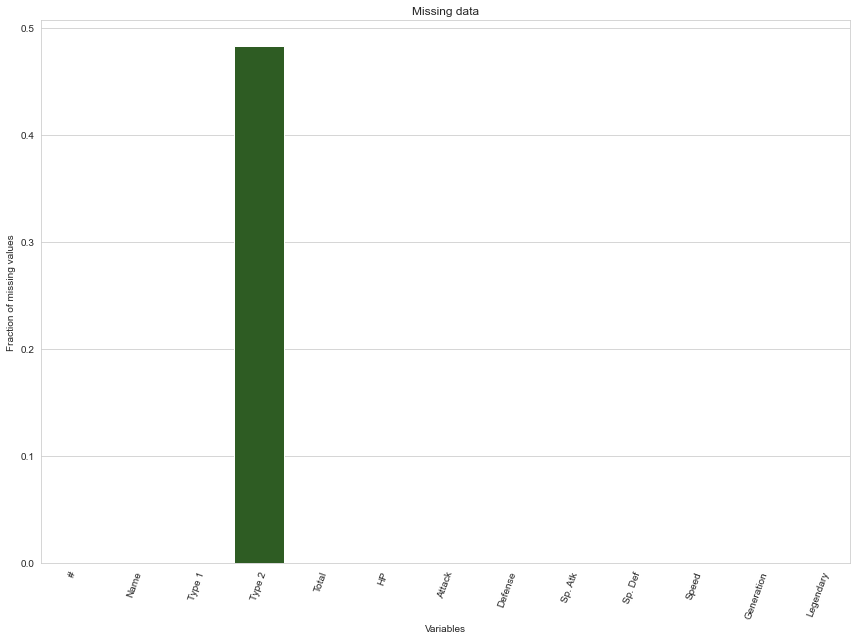

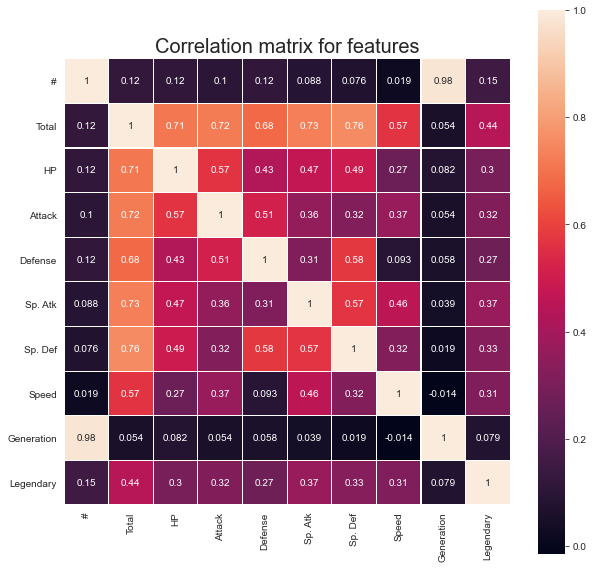

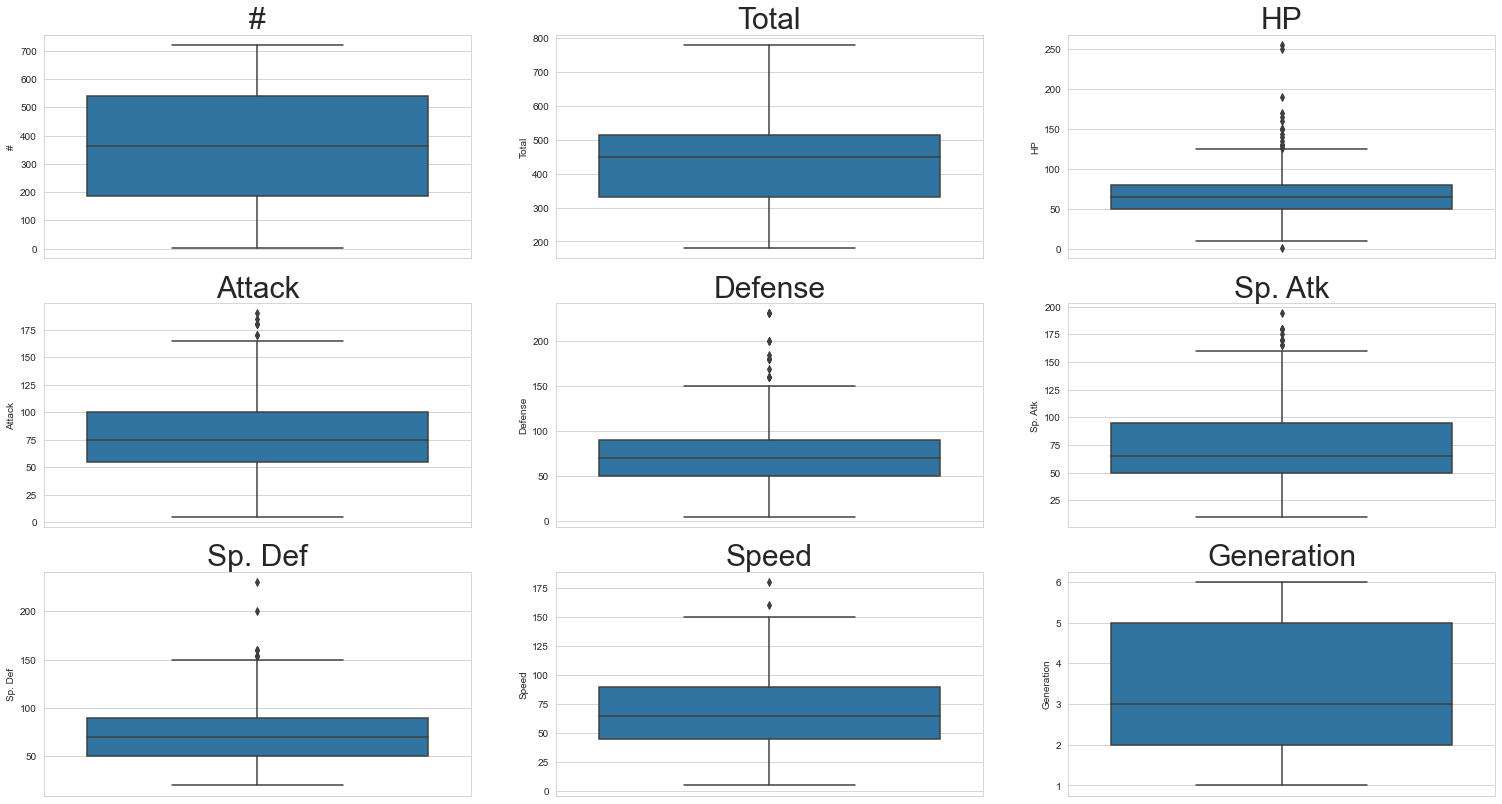

In [50]:
from my_awesome_eda import run_eda

run_eda(pokemon)

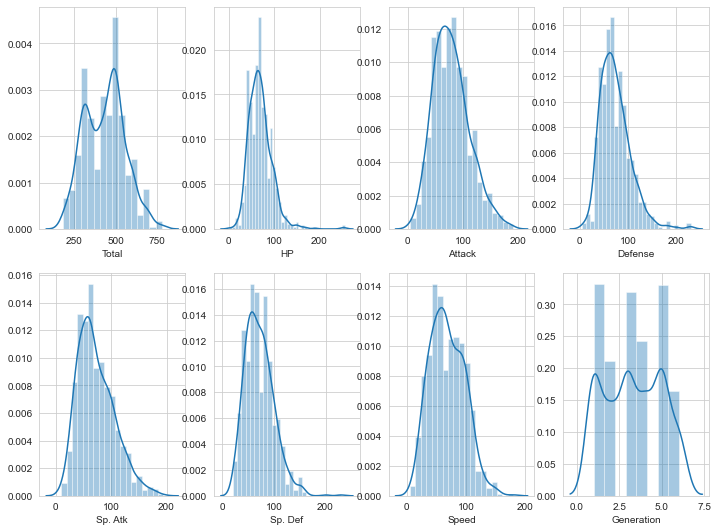

In [51]:
#И дополним Распределениями
numeric_cols = list(pokemon.select_dtypes(include=np.number).columns)
numeric_cols.remove('#')

fig, axes = plt.subplots(nrows=2, ncols=4)
for i, column in enumerate(numeric_cols):
    sns.distplot(pokemon[column],ax=axes[i//4, i%4])

AttributeError: module 'seaborn' has no attribute 'sns'

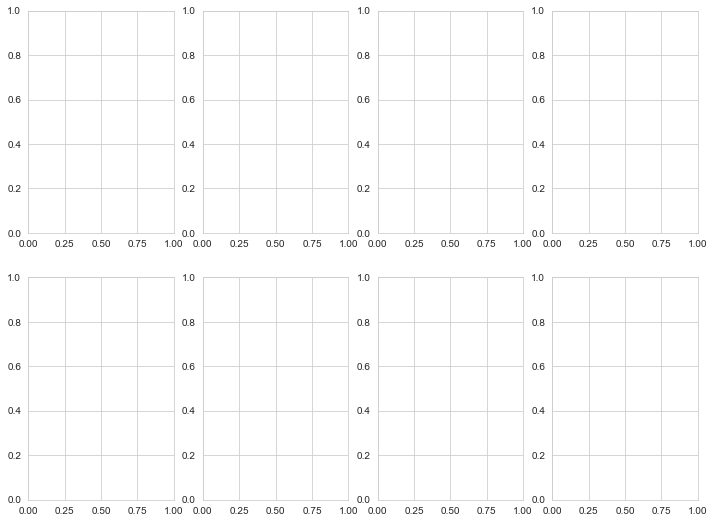

In [52]:
# ну и скеттер плоты для переменных х - колонки, y - целевая переменная
fig, axes = plt.subplots(nrows=2, ncols=4)
for i, column in enumerate(numeric_cols):
    sns.sns.scatterplot(pokemon[column],ax=axes[i//4, i%4], hue='Legendary')

In [ ]:
numeric_cols.append('Legendary')
sns.pairplot(
    data=pokemon[numeric_cols],
    hue='Legendary')

Итого:
Можно дропнуть такие колонки как #, Name, т.к. это как идентификаторы покемонов, которые не влияют на способности. 
Также можно дропнуть Type2 колонку, а то много NA так. 
Из матрицы корреляции видно, что с легендарностью сильно ничего не коррелирует. А вот с Total показатели Attack, Defense, Sp. Atk, Sp. Def. Что в целом логично, если я правильно понимаю, тотал из них и высчиытвается (так что что-нибудь из этого можно дропнуть).

In [ ]:
#дропаем часть колонок
pokemon = pokemon.drop(['#','Name','Type 2'], axis = 1)
pokemon.head()

In [ ]:
pokemon.head()

In [ ]:
pokemon['Legendary'].astype(np.int)

Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [ ]:
#Заменяем bool на int (0,1)
pokemon["Legendary"] = pokemon["Legendary"].astype(int)

#мы уже часть дропнули колонок. Можно пока дропнуть и тип 1
pokemon = pokemon.drop(['Type 1'], axis = 1)#чекнем потом с ним

Разделите ваши данные на тестовую и тренировочную выборку.

In [ ]:
#разбивка
X = pokemon.drop('Legendary', axis=1)
y = pokemon['Legendary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = SEED)

In [ ]:
#можно ещё отскейлить
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Обучите модель `LogisticRegression` из `sklearn`.

In [ ]:
#Модель
clf = LogisticRegression(random_state = SEED).fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

In [ ]:
area

In [ ]:
#ROC
from sklearn.metrics import plot_roc_curve

area = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
plot_roc_curve(clf, X_test, y_test) 
plt.text(x = 0.5, y = 0.5, s = f'AUC = {str(np.round(area, decimals=2))}', size = 15, color = 'black')
plt.show()

In [ ]:
#важность признаков
model_feature = pokemon.columns
model_feature.insert(0, 'intercept')
indexes = np.argsort(np.abs(clf.coef_), )[::-1]
print(f'По убыванию важности признака: {[model_feature[i] for i in indexes]}')

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**